# Speech Emotion Recognition with ConvNet and MFCCs

Hello!

This notebook includes the exploration of different audio samples and the application of a **Convolutional Neural Network** that exclusively uses **Mel-Frequency Cepstral Components (MFCCs)** for emotion classification. The datasets used here are **TESS**, **RAVDESS** and **SAVEE**.

In [1]:
# Importing libraries
import os
import pandas as pd
import random
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

### Getting the data

In [2]:
# Getting TESS data:
paths, labels, duration = [], [], []

for dirname, _, filenames in os.walk('../input/toronto-emotional-speech-set-tess'):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        duration.append(round(librosa.get_duration(filename=paths[-1]), 3))
        
        label = filename[::-1].split('_')[0][::-1]
        labels.append(label[:-4].lower())

df_tess = pd.DataFrame({'path':paths,'duration': duration, 'dataset': 'TESS', 'emotion':labels})

df_tess['emotion'] = df_tess['emotion'].replace(['ps'], 'surprise')
                  
df_tess.sample(5)

,path,duration,dataset,emotion
3224,../input/toronto-emotional-speech-set-tess/tes...,1.605,TESS,fear
5596,../input/toronto-emotional-speech-set-tess/tes...,1.879,TESS,surprise
3834,../input/toronto-emotional-speech-set-tess/tes...,2.208,TESS,angry
761,../input/toronto-emotional-speech-set-tess/TES...,2.512,TESS,disgust
5051,../input/toronto-emotional-speech-set-tess/tes...,1.905,TESS,happy


In [3]:
# Getting RAVDESS data
paths, labels, duration = [], [], []

for dirname, _, filenames in os.walk('../input/ravdess-emotional-speech-audio'):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        duration.append(round(librosa.get_duration(filename=paths[-1]), 3)) 
        
        label = filename[::-1].split('_')[0][::-1]
        
        if label[6:8] == '01':
            labels.append('neutral')
        elif label[6:8] == '02':
            labels.append('calm')
        elif label[6:8] == '03':
            labels.append('happy')
        elif label[6:8] == '04':
            labels.append('sad')
        elif label[6:8] == '05':
            labels.append('angry')
        elif label[6:8] == '06':
            labels.append('fear')
        elif label[6:8] == '07':
            labels.append('disgust')
        elif label[6:8] == '08':
            labels.append('surprise')       

df_ravdess = pd.DataFrame({'path':paths,'duration': duration, 'dataset': 'RAVDESS', 'emotion':labels})

df_ravdess.sample(5)

,path,duration,dataset,emotion
2746,../input/ravdess-emotional-speech-audio/Actor_...,3.070,RAVDESS,neutral
2396,../input/ravdess-emotional-speech-audio/audio_...,3.470,RAVDESS,neutral
937,../input/ravdess-emotional-speech-audio/Actor_...,3.770,RAVDESS,sad
1057,../input/ravdess-emotional-speech-audio/Actor_...,3.737,RAVDESS,neutral
967,../input/ravdess-emotional-speech-audio/Actor_...,3.704,RAVDESS,sad


In [4]:
# Getting SAVEE data
paths, labels, duration = [], [], []

for dirname, _, filenames in os.walk('../input/savee-database/AudioData/'):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        label = filename[::-1].split('_')[0][::-1]
        
        if label[:1] == 'a':
            labels.append('angry')
        elif label[:1] == 'd':
            labels.append('disgust')
        elif label[:1] == 'f':
            labels.append('fear')
        elif label[:1] == 'h':
            labels.append('happy')
        elif label[:1] == 'n':
            labels.append('neutral')
        elif label[:1] == 's':
            if label[:2] == 'sa':
                labels.append('sad')
            else:
                labels.append('surprise')

paths = paths[1:] # to filter out 'info.txt' file

for file in paths:
    duration.append(round(librosa.get_duration(filename=file), 3)) 

df_savee = pd.DataFrame({'path':paths, 'duration': duration, 'dataset': 'SAVEE', 'emotion':labels})
                  
df_savee.sample(5)

,path,duration,dataset,emotion
38,../input/savee-database/AudioData/DC/d02.wav,3.920,SAVEE,disgust
77,../input/savee-database/AudioData/DC/n16.wav,3.816,SAVEE,neutral
170,../input/savee-database/AudioData/JE/n11.wav,5.332,SAVEE,neutral
386,../input/savee-database/AudioData/JK/sa04.wav,5.648,SAVEE,sad
305,../input/savee-database/AudioData/KL/su11.wav,2.014,SAVEE,surprise


In [5]:
# Let's merge the datesets together, now that they have been formatted the same way:

df = pd.concat([df_tess, df_ravdess, df_savee])

# Dropping 'calm' as out the scope (also not many samples)
df = df[df['emotion'].str.contains('calm') == False].reset_index(drop=True)

print('The dataset has {} audio files. Below printed 5 random entries:'.format(df.shape[0]))

df.sample(5)

The dataset has 8576 audio files. Below printed 5 random entries:


,path,duration,dataset,emotion
6325,../input/ravdess-emotional-speech-audio/Actor_...,3.871,RAVDESS,happy
5038,../input/toronto-emotional-speech-set-tess/tes...,1.925,TESS,happy
7352,../input/ravdess-emotional-speech-audio/audio_...,3.871,RAVDESS,angry
5240,../input/toronto-emotional-speech-set-tess/tes...,2.516,TESS,sad
1153,../input/toronto-emotional-speech-set-tess/TES...,2.102,TESS,angry


### Exploratory Data Analysis (EDA)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 0 to 8575
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   path      8576 non-null   object 
 1   duration  8576 non-null   float64
 2   dataset   8576 non-null   object 
 3   emotion   8576 non-null   object 
dtypes: float64(1), object(3)
memory usage: 268.1+ KB


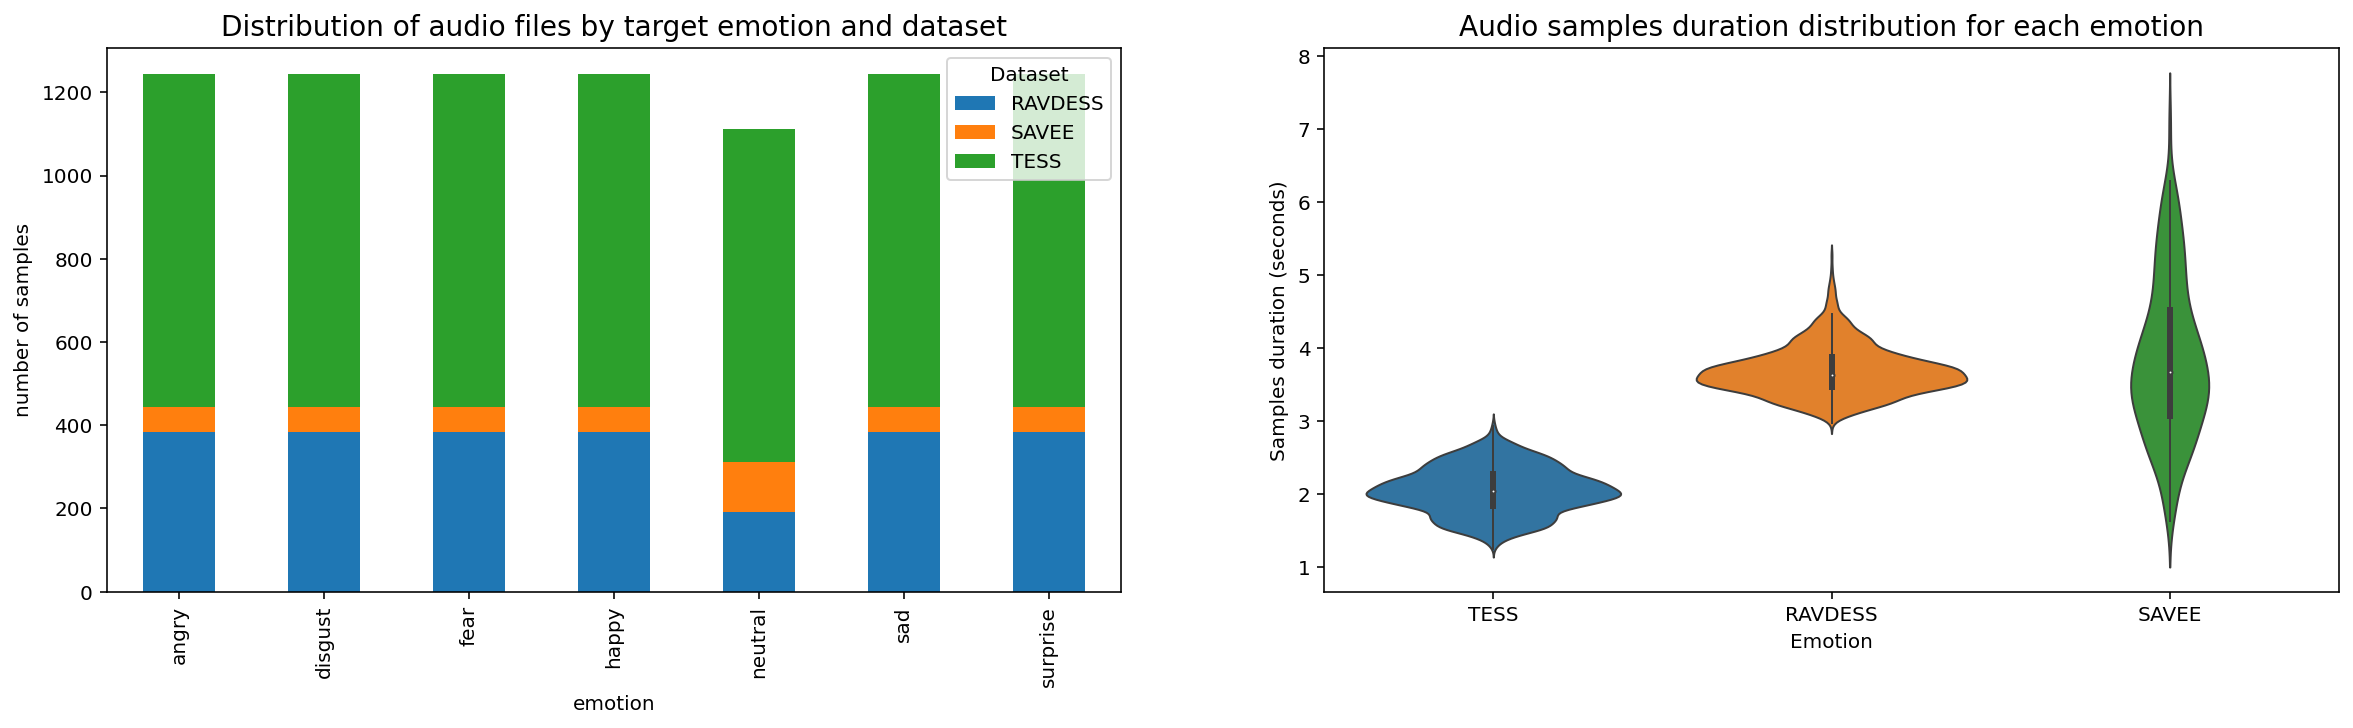

In [7]:
# Creating a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Check samples distribution
df.groupby(['emotion','dataset']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Distribution of audio files by target emotion and dataset', size=14)
axes[0].set_ylabel('number of samples')
axes[0].legend(title='Dataset')

# Check duration distribution by each source using violin plots
sns.violinplot(x=df['dataset'],y=df['duration'], linewidth=1, ax=axes[1])
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Samples duration (seconds)')
axes[1].set_title('Audio samples duration distribution for each emotion', size=14)

plt.show()

We can note that samples distribution is similar for each target, with 1100~1200 files per category. Overall, the samples length is similar across each source.

Finally, now let's look at what is **inside the audio files**, picking some random samples from different targets. In particular I want to check:
- the **waveforms**
- the **spectograms, with the fundamental frequency**
- the **Mel-frequency cepstrum components (MFCCs)**, as "two-dimensional images".
- and of course hear how they sound, using the built-in **media player** of python

In [8]:
# function to display samples information by emotion
# note that a random samples is generated each time the function is called
# this is on purpose as to check different samples of each emotion every time

def show_audio(emotion):
    # create sublots
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
    # filter dataframe to emotion)
    df_show = df.loc[df['emotion'] == emotion].reset_index(drop=True)
    index = random.randint(0, df_show.shape[0])
    
    # load audio file:
    y, sr = librosa.load(df_show.path[index], sr=16000)
    
    # Show waveform
    librosa.display.waveshow(y, sr=sr, ax=axs[0])
    axs[0].set_title('Waveform')
    
    # Extract fundamental frequency (f0) using a probabilistic approach
    f0, _, _ = librosa.pyin(y, sr=sr, fmin=50, fmax=1500, frame_length=2048)

    # Establish timepoint of f0 signal
    timepoints = np.linspace(0, df_show.duration[index], num=len(f0), endpoint=False)
    
    # Compute short-time Fourier Transform
    x_stft = np.abs(librosa.stft(y))
    
    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
    
    # Plot STFT spectrogram
    librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log", ax=axs[1])
    
    # Plot fundamental frequency (f0) in spectrogram plot
    axs[1].plot(timepoints, f0, color="cyan", linewidth=4)
    axs[1].set_title('Spectrogram with fundamental frequency')
    
    # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
    x_mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)

    # Plot MFCCs
    librosa.display.specshow(x_mfccs, sr=sr, x_axis="time", norm=Normalize(vmin=-50, vmax=50), ax=axs[2])
    axs[2].set_title('MFCCs')
    
    # Show metadata in title
    plt.suptitle('File: {}  -  Emotion: {}'.format(df_show.path[index], df_show.emotion[index]), size=14)
    plt.tight_layout()
    plt.show()
    
    # Display media player for the selected file
    display(ipd.Audio(y, rate=sr))

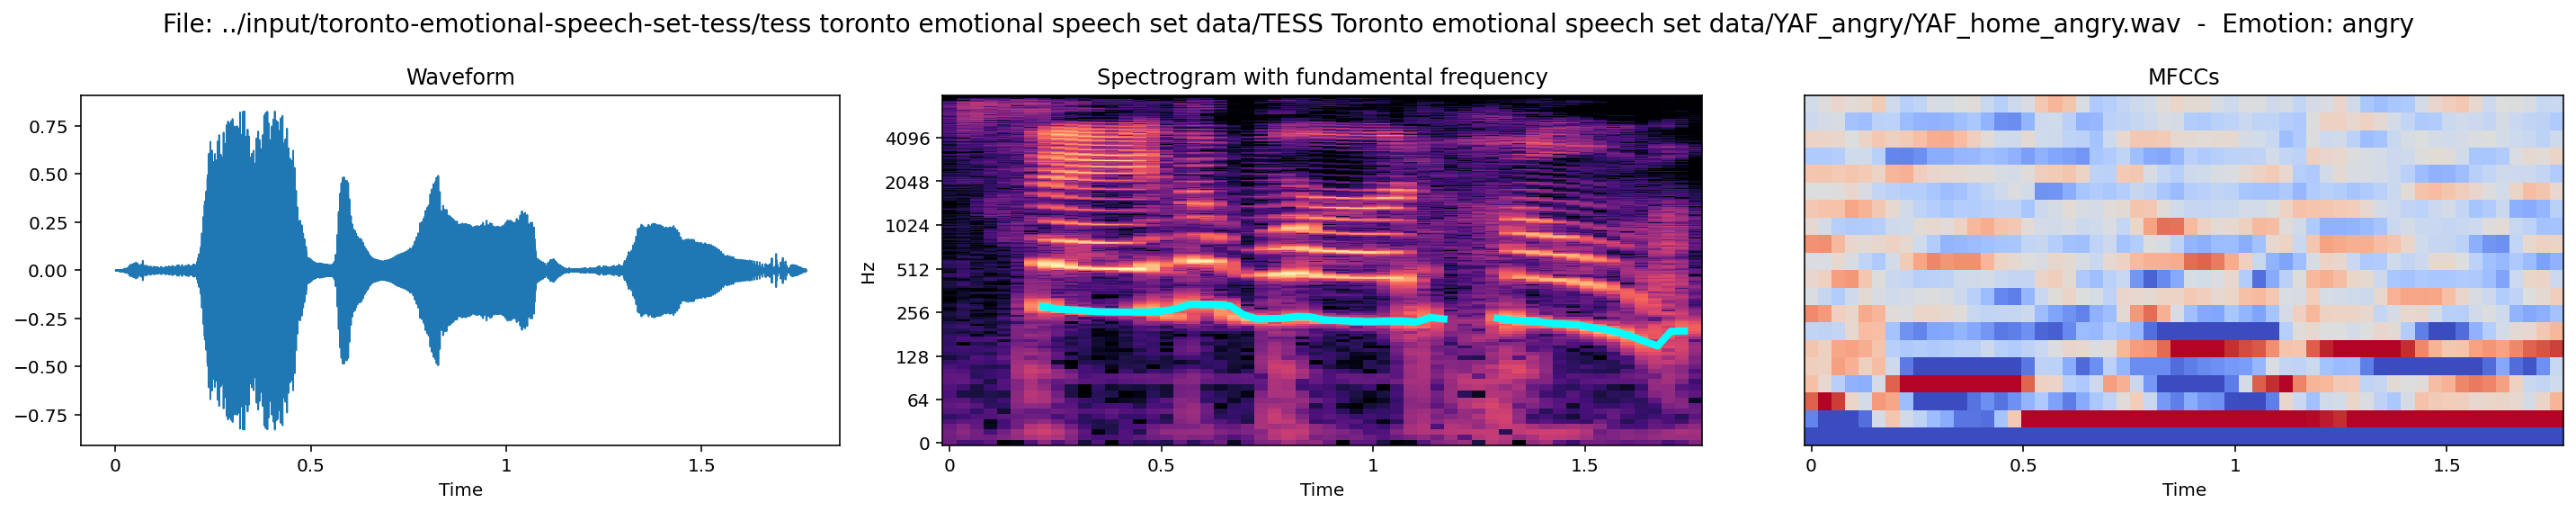

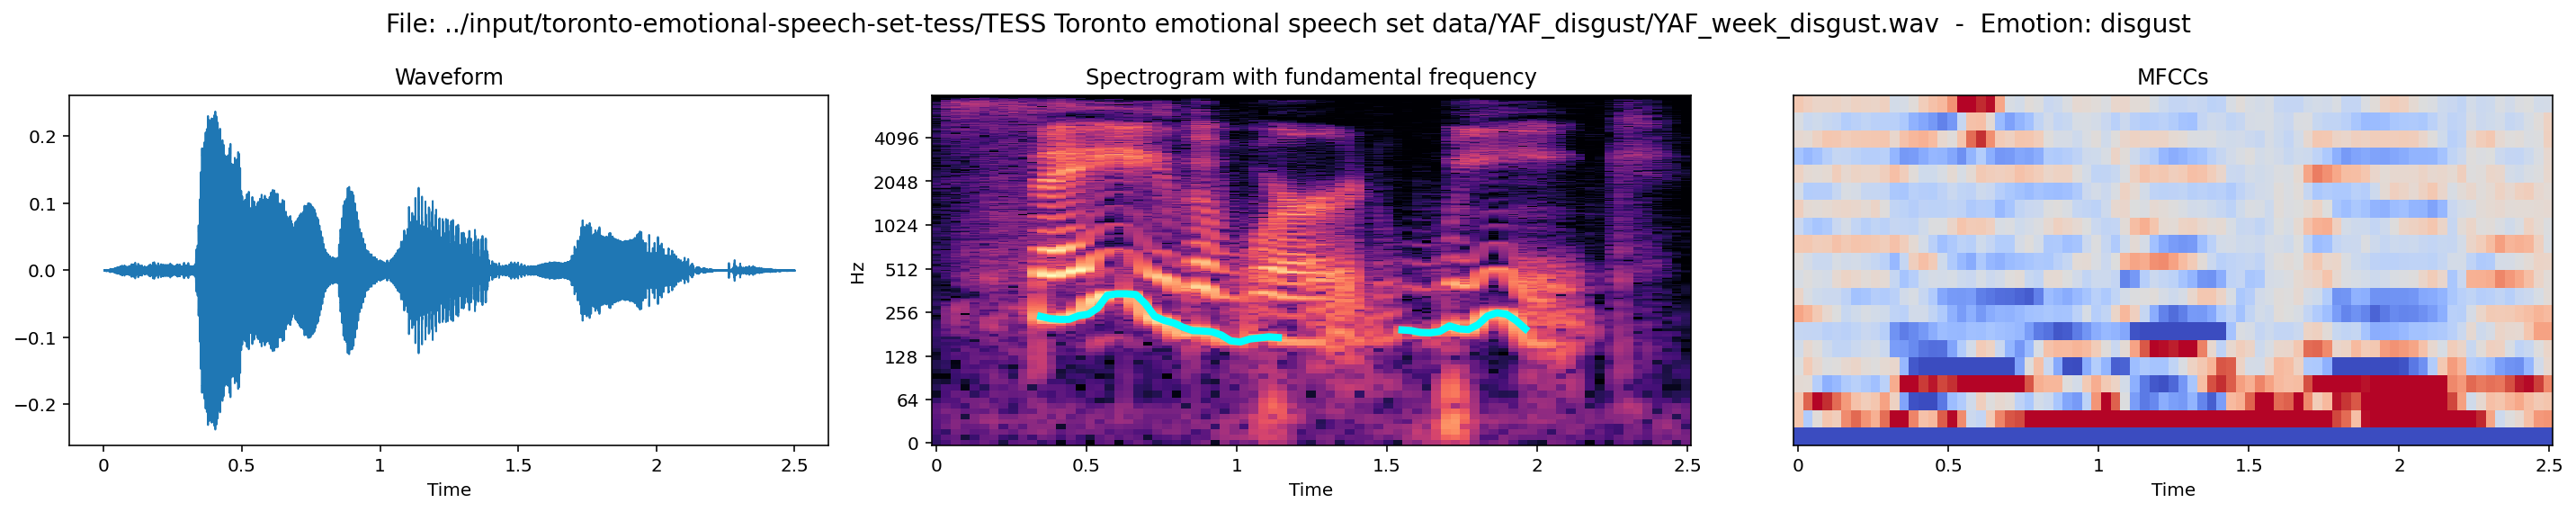

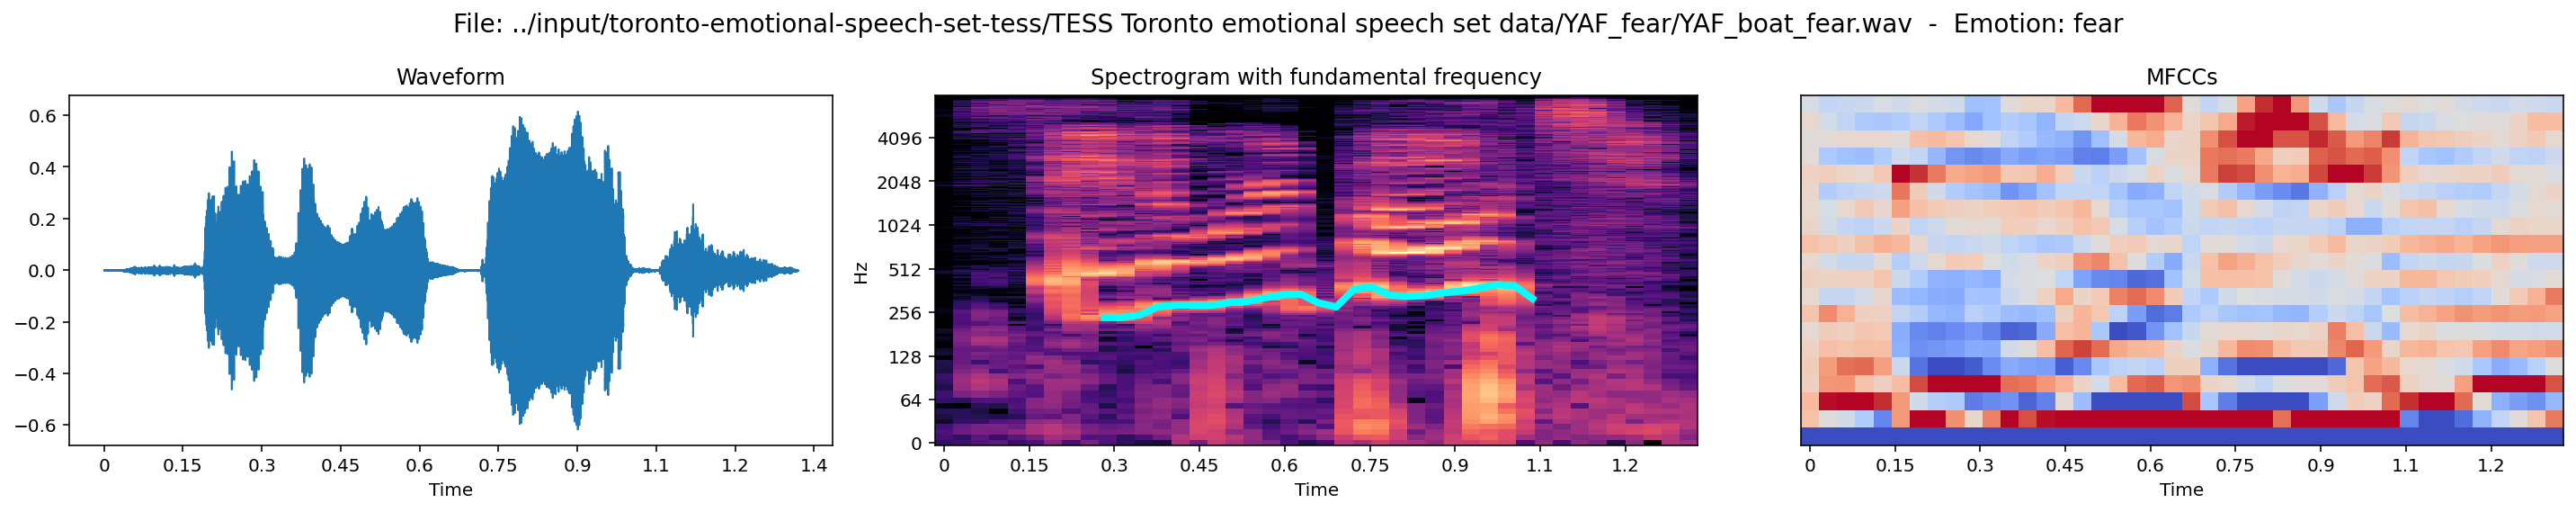

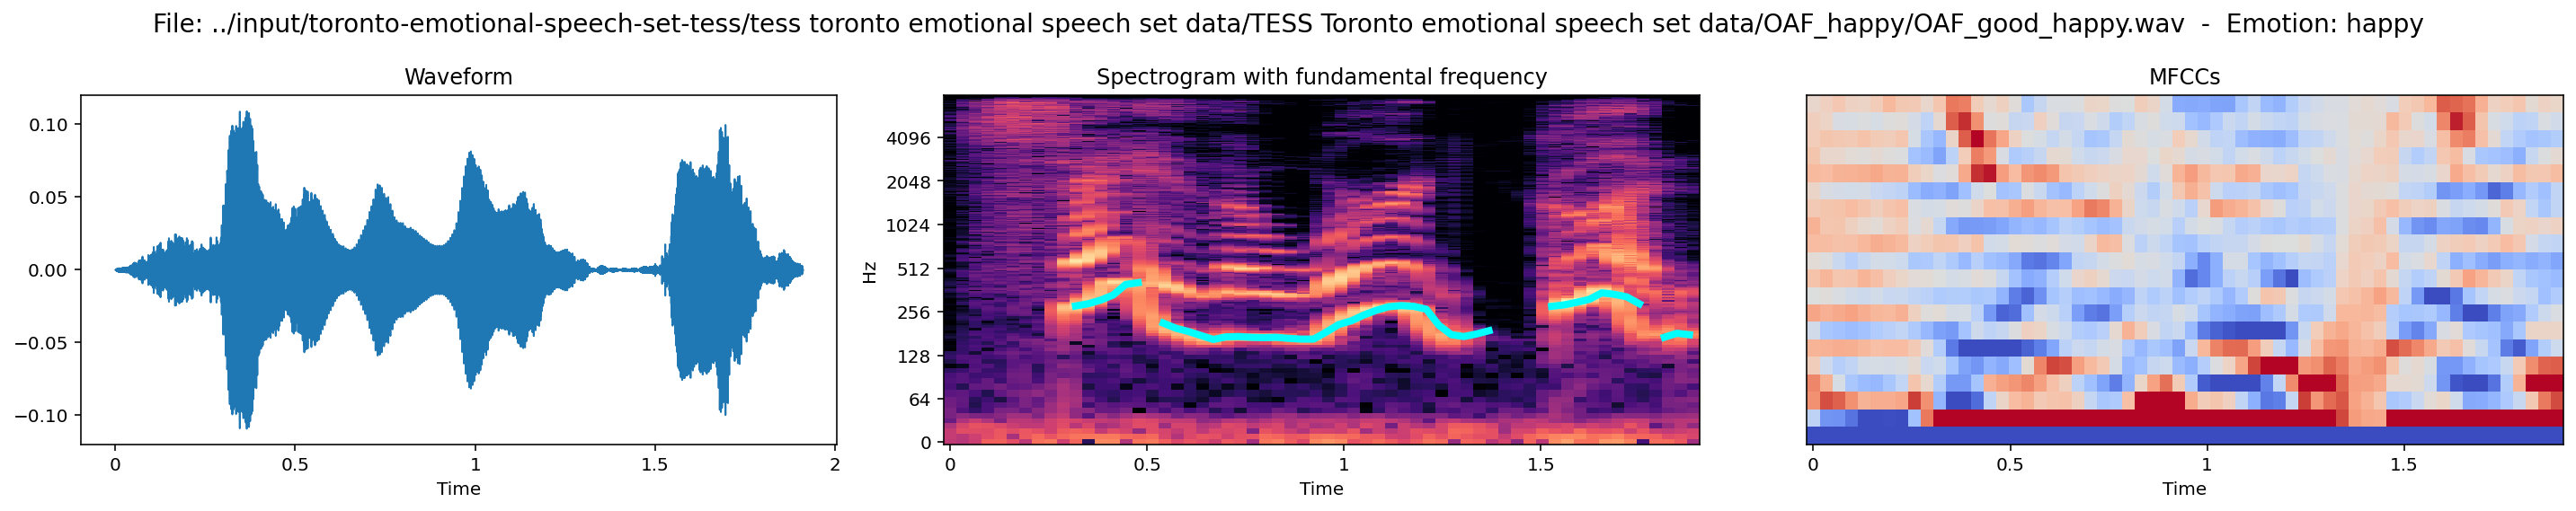

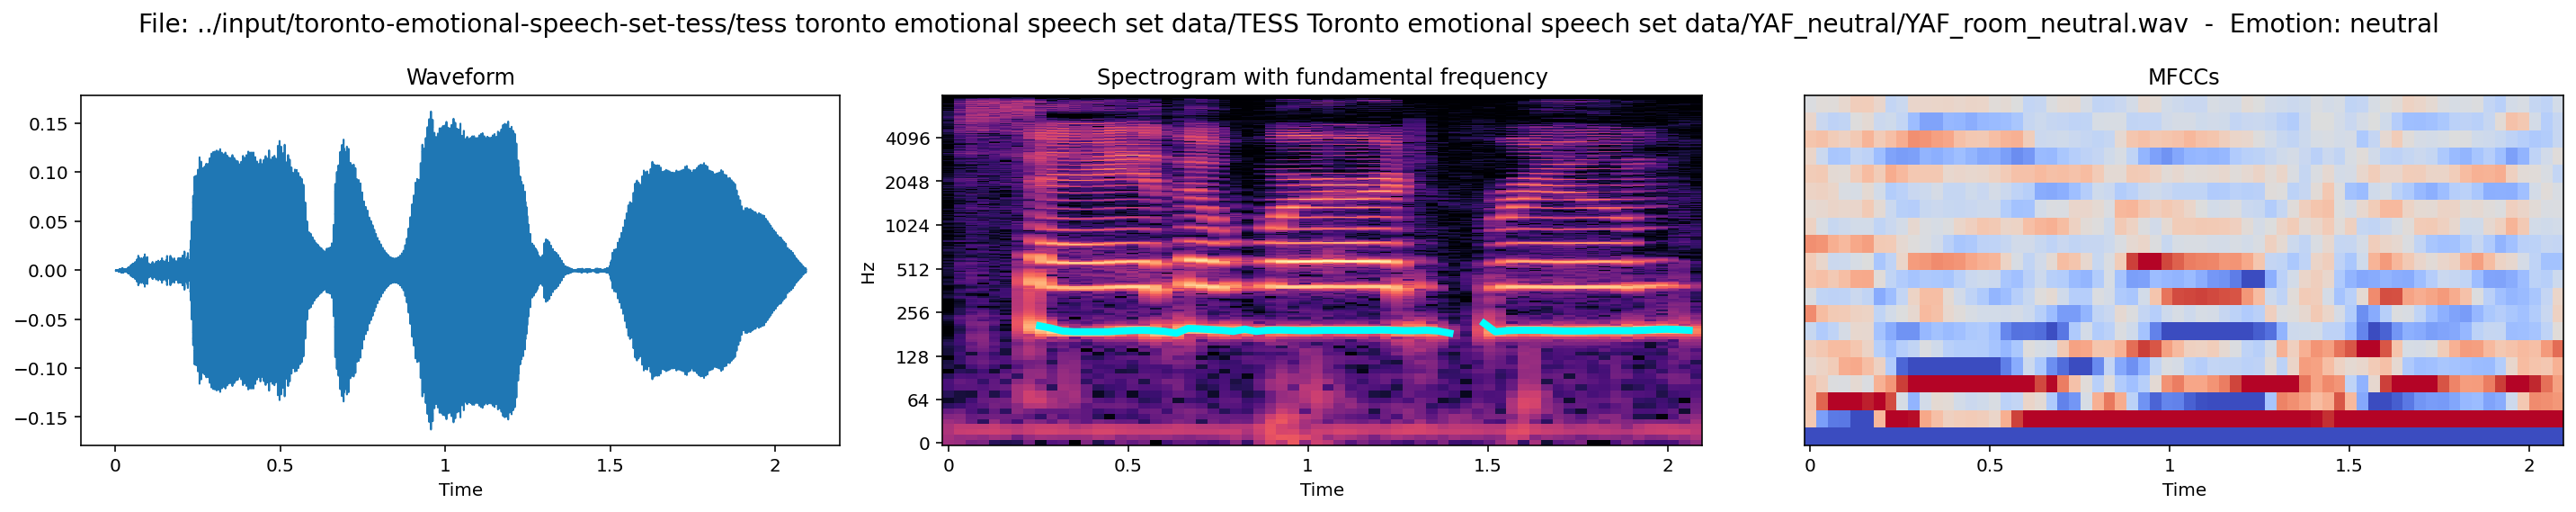

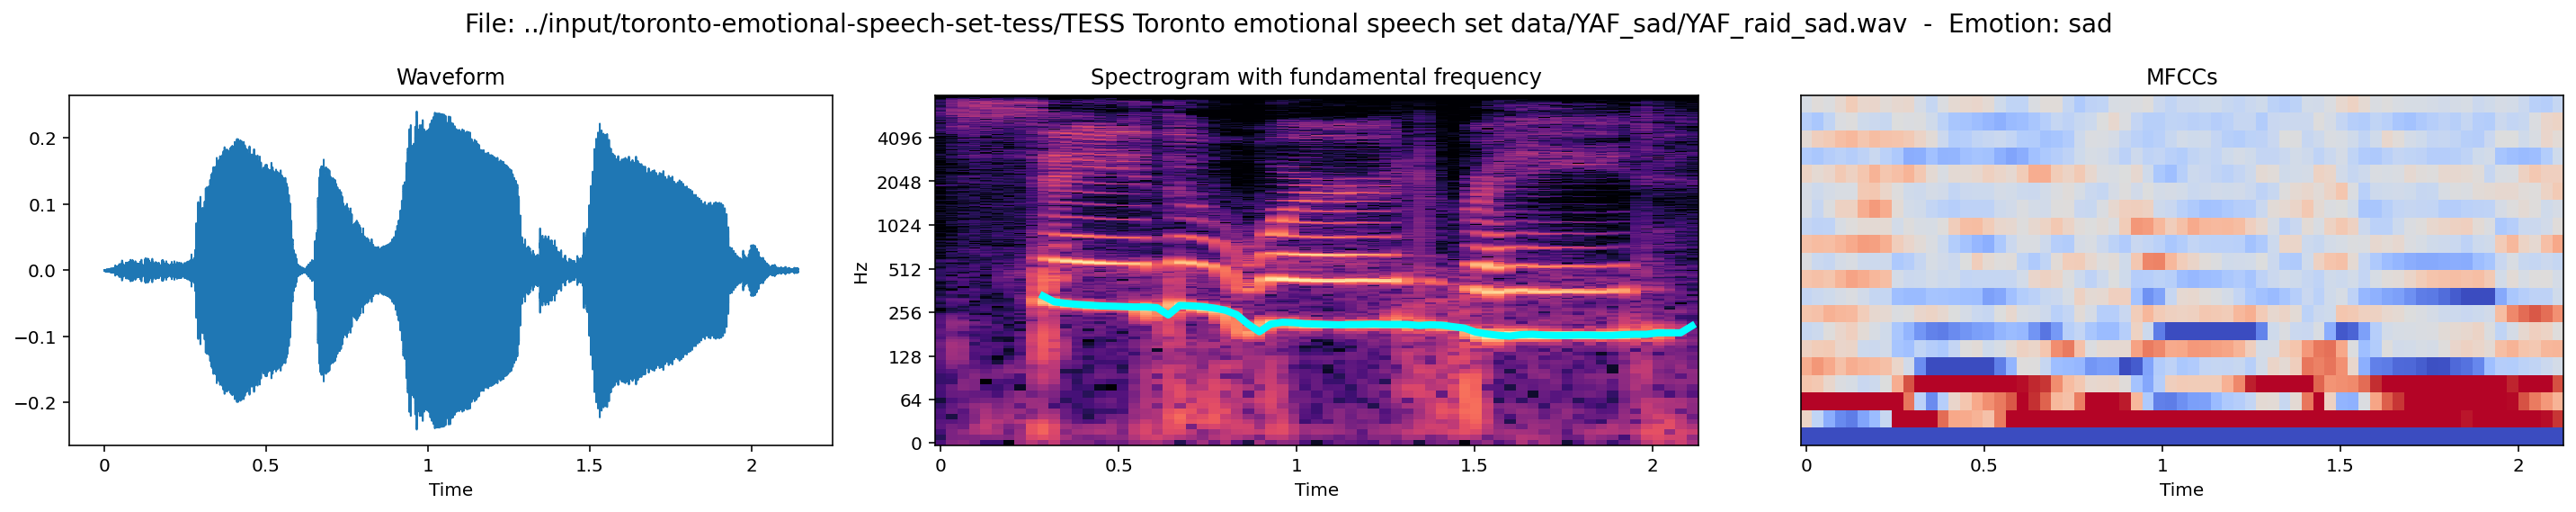

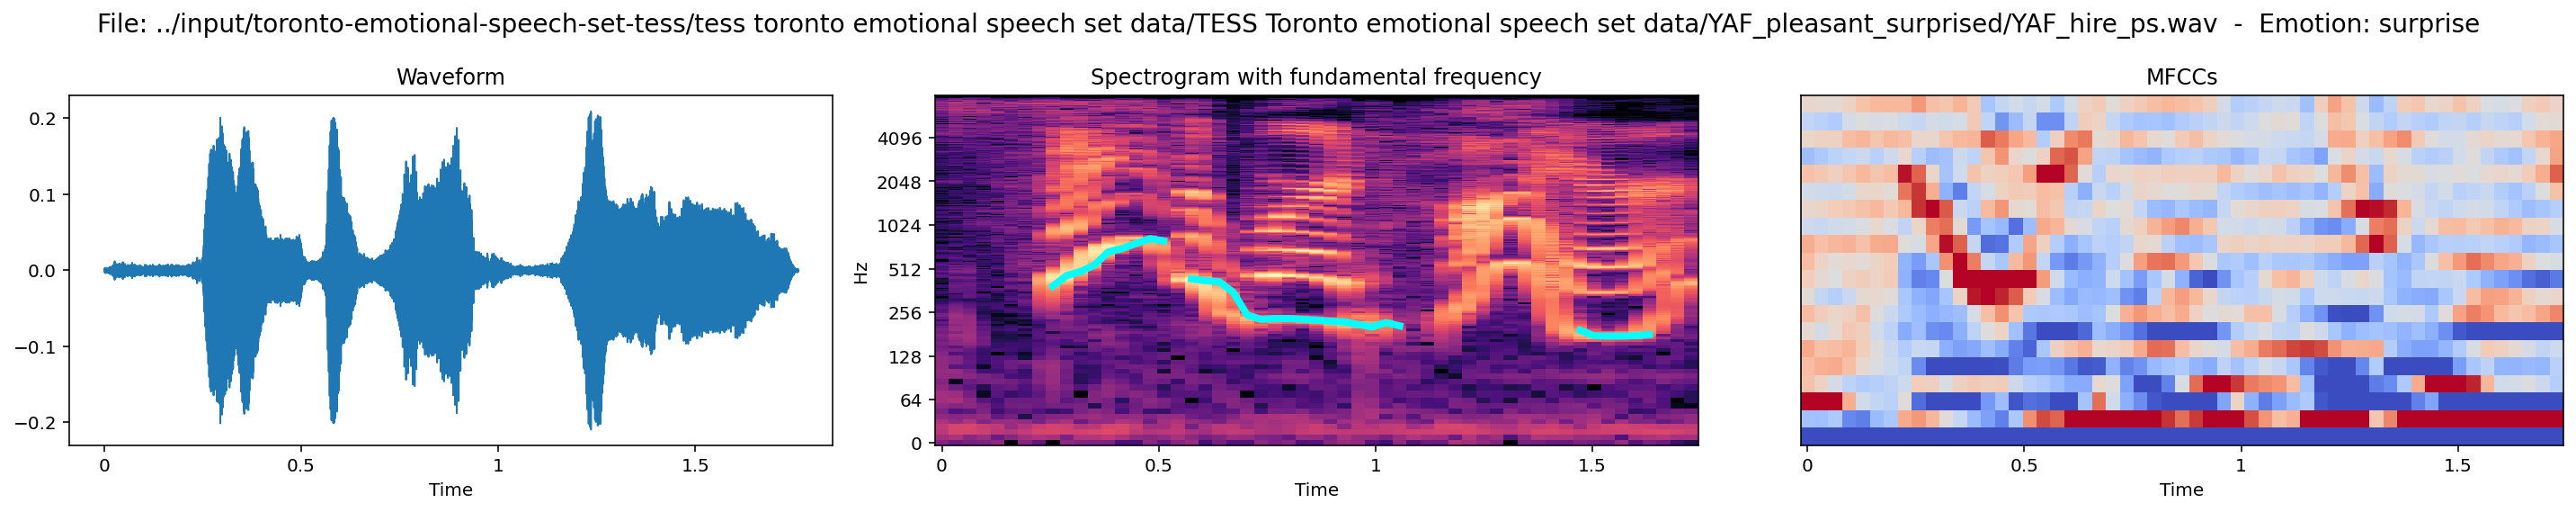

In [9]:
# Getting ordered list of emotions ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotions = sorted(list(df.emotion.unique()))

# Get waveforms, spectograms, mfccs and media player for each emotion
for emotion in emotions:
    show_audio(emotion)

### Getting MFCCs

For a proper modeling, the audio samples should be trimmed (i.e., removing initial and ending silences), and get some tailored noise reduction techniques.

However, in this case we will directly extract the MFCCs information from the audio files, as "two-dimensional images".

I chose to obtain 30 components for each sample, which will create a 2D arrays with the sound characteristics of the files. This operation may require some time.

In [10]:
%%time

# Create a variable where to store the mfccs data
mfccs = []

for file in df.path:
    # load audio file:
    y, sr = librosa.load(file, sr=16000)
    
    # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
    mfccs.append(librosa.feature.mfcc(y, sr=sr, fmin=50, n_mfcc=30))

CPU times: user 44min 5s, sys: 29min 53s, total: 1h 13min 59s
Wall time: 23min 35s


Since the samples have different durations, we need to reshape these two-dimensional arrays in order to feed correctly the convolutional model. For this reason, I apply a function to have the files to the same shape of 30x150, which corresponds to about 4.5 seconds of audio. This also means that files that are shorter will have an additional silent part to reach this threshold (zeros padding), while longer files will be cut off.

In [11]:
# Define function to resize the 2D arrays
def resize_array(array):
    new_matrix = np.zeros((30,150))   # Initialize the new matrix shape with an array 30X150 of zeros
    for i in range(30):               # Iterate rows
        for j in range(150):          # Iterate columns
            try:                                 # the mfccs of a sample will replace the matrix of zeros, then cutting the array up to 150
                new_matrix[i][j] = array[i][j]
            except IndexError:                   # if mfccs of a sample is shorter than 150, then keep looping to extend lenght to 150 with 0s
                pass
    return new_matrix

# Create a variable to store the new resized mfccs and apply function for all the extracted mfccs
resized_mfccs = []

for mfcc in mfccs:
    resized_mfccs.append(resize_array(mfcc))

Let's visualize few MFCCs with the new shape:

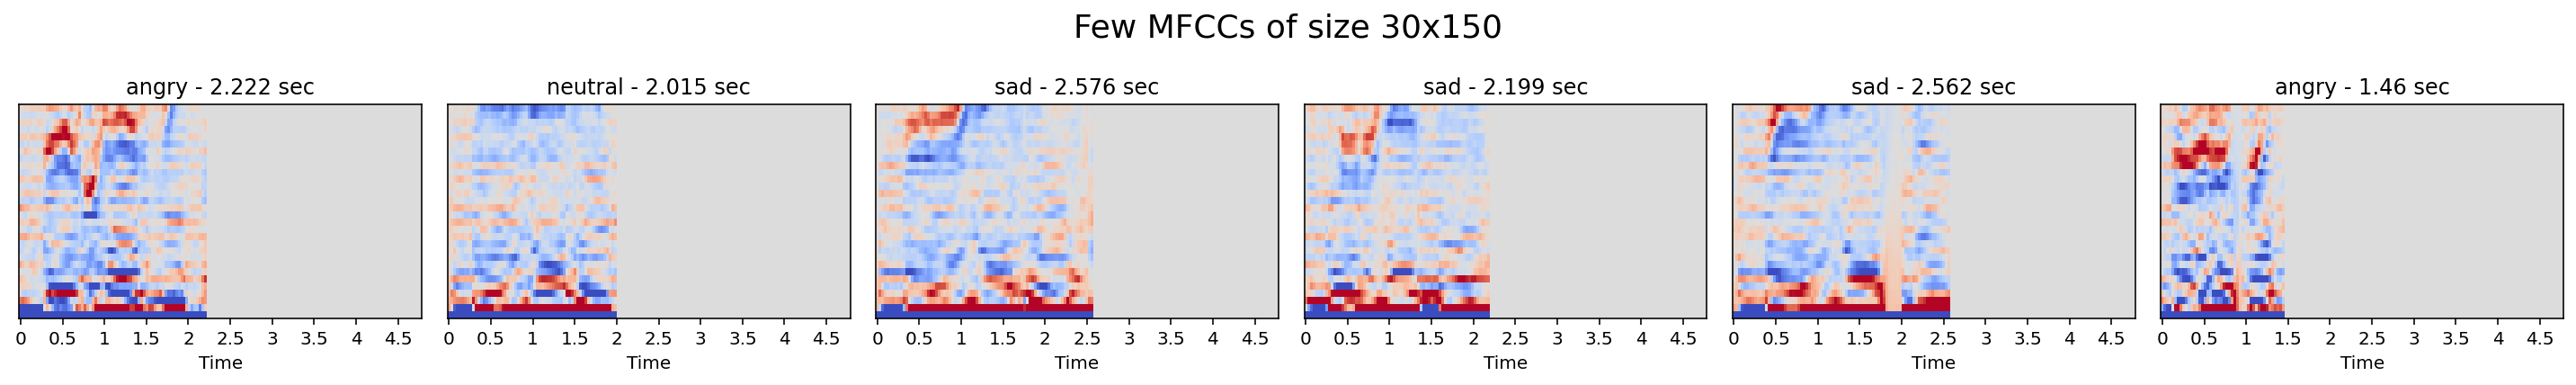

In [12]:
# Create sublots
fig, axs = plt.subplots(nrows=1,ncols=6, figsize=(20,3))

# Select 6 random MFCCs
for i in range(6):
    index = random.randint(0, len(resized_mfccs))
    
    # Plot MFCCs
    librosa.display.specshow(resized_mfccs[index], sr=sr, x_axis="time", ax=axs[i], norm=Normalize(vmin=-50, vmax=50))
    axs[i].set_title(str(df.emotion[index]) + ' - ' + str(df.duration[index]) + ' sec')

plt.suptitle('Few MFCCs of size 30x150', size=18)
plt.tight_layout()
plt.show()

Great, the reshaping function worked as expected, cutting the MFCC spectrum of the longer samples to ~4.5 seconds and adding silence for the shorter files to reach the same length.

##  Convolutional Neural Network model

Let's split the data into train, validation and test set:

In [13]:
from sklearn.model_selection import train_test_split

# Select target
df['emotion'].replace({'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}, inplace=True)
y = df.emotion.values

# Features
X = resized_mfccs.copy()

# Create train, validation and test set
x_tr, x_te, y_tr, y_te = train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)
x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size=0.3, shuffle=True, random_state=0)

# Convert data to numpy arrays
x_tr = np.array([i for i in x_tr])
x_va = np.array([i for i in x_va])
x_te = np.array([i for i in x_te])

# Plot size of data
print(x_tr.shape)
print(x_va.shape)
print(x_te.shape)

(5402, 30, 150)
(2316, 30, 150)
(858, 30, 150)


The data also should be scaled in order to be used properly in a convolutional neural network. This transformation can be done manually by applying the mean and standard deviation from the training set also to the other sets.

In [14]:
# Get mean and standard deviation from the training set
tr_mean = np.mean(x_tr, axis=0)
tr_std = np.std(x_tr, axis=0)

# Apply data scaling
x_tr = (x_tr - tr_mean)/tr_std
x_va = (x_va - tr_mean)/tr_std
x_te = (x_te - tr_mean)/tr_std

Another necessary operation is to add another 'dimension' to the data:

In [15]:
# Add the 'channel' dimension to the MFCCs spectrum input 'images'
print(f"x_tr has a dimension of {x_tr.shape} before the manipulation.")

x_tr = x_tr[..., None]
x_va = x_va[..., None]
x_te = x_te[..., None]

print(f"x_tr has a dimension of {x_tr.shape} after the manipulation.")

x_tr has a dimension of (5402, 30, 150) before the manipulation.
x_tr has a dimension of (5402, 30, 150, 1) after the manipulation.


Let's define the Convolutional Neural Network model using Tensorflow:

In [16]:
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D)
from tensorflow.keras import initializers

# Create convolutional neural network and return summary
model = keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=5, strides=(2, 2), activation="relu", input_shape=x_tr.shape[1:]))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=4, strides=(2, 1), activation="relu"))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=7, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 73, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 36, 64)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 36, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 33, 32)         32800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 16, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 16, 32)         128       
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

Before fitting the model I will provide an EarlyStopping callback function.

In [17]:
# Compile the model using Adam's default learning rate
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Create 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=5)

Fit the model:

In [18]:
%%time

#  Train the neural network
history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=32,
    validation_data=(x_va, y_va),
    callbacks=[earlystopping_cb]
)

Epoch 1/100
169/169 [==============================] - 5s 24ms/step - loss: 2.1353 - accuracy: 0.2960 - val_loss: 1.4732 - val_accuracy: 0.5073
Epoch 2/100
169/169 [==============================] - 4s 22ms/step - loss: 1.2800 - accuracy: 0.5333 - val_loss: 0.8771 - val_accuracy: 0.7073
Epoch 3/100
169/169 [==============================] - 4s 21ms/step - loss: 0.9707 - accuracy: 0.6451 - val_loss: 0.6998 - val_accuracy: 0.7422
Epoch 4/100
169/169 [==============================] - 4s 21ms/step - loss: 0.8261 - accuracy: 0.6916 - val_loss: 0.6640 - val_accuracy: 0.7465
Epoch 5/100
169/169 [==============================] - 4s 22ms/step - loss: 0.7623 - accuracy: 0.7131 - val_loss: 0.6564 - val_accuracy: 0.7526
Epoch 6/100
169/169 [==============================] - 4s 21ms/step - loss: 0.7130 - accuracy: 0.7355 - val_loss: 0.6443 - val_accuracy: 0.7660
Epoch 7/100
169/169 [==============================] - 4s 21ms/step - loss: 0.6800 - accuracy: 0.7453 - val_loss: 0.6171 - val_accuracy:

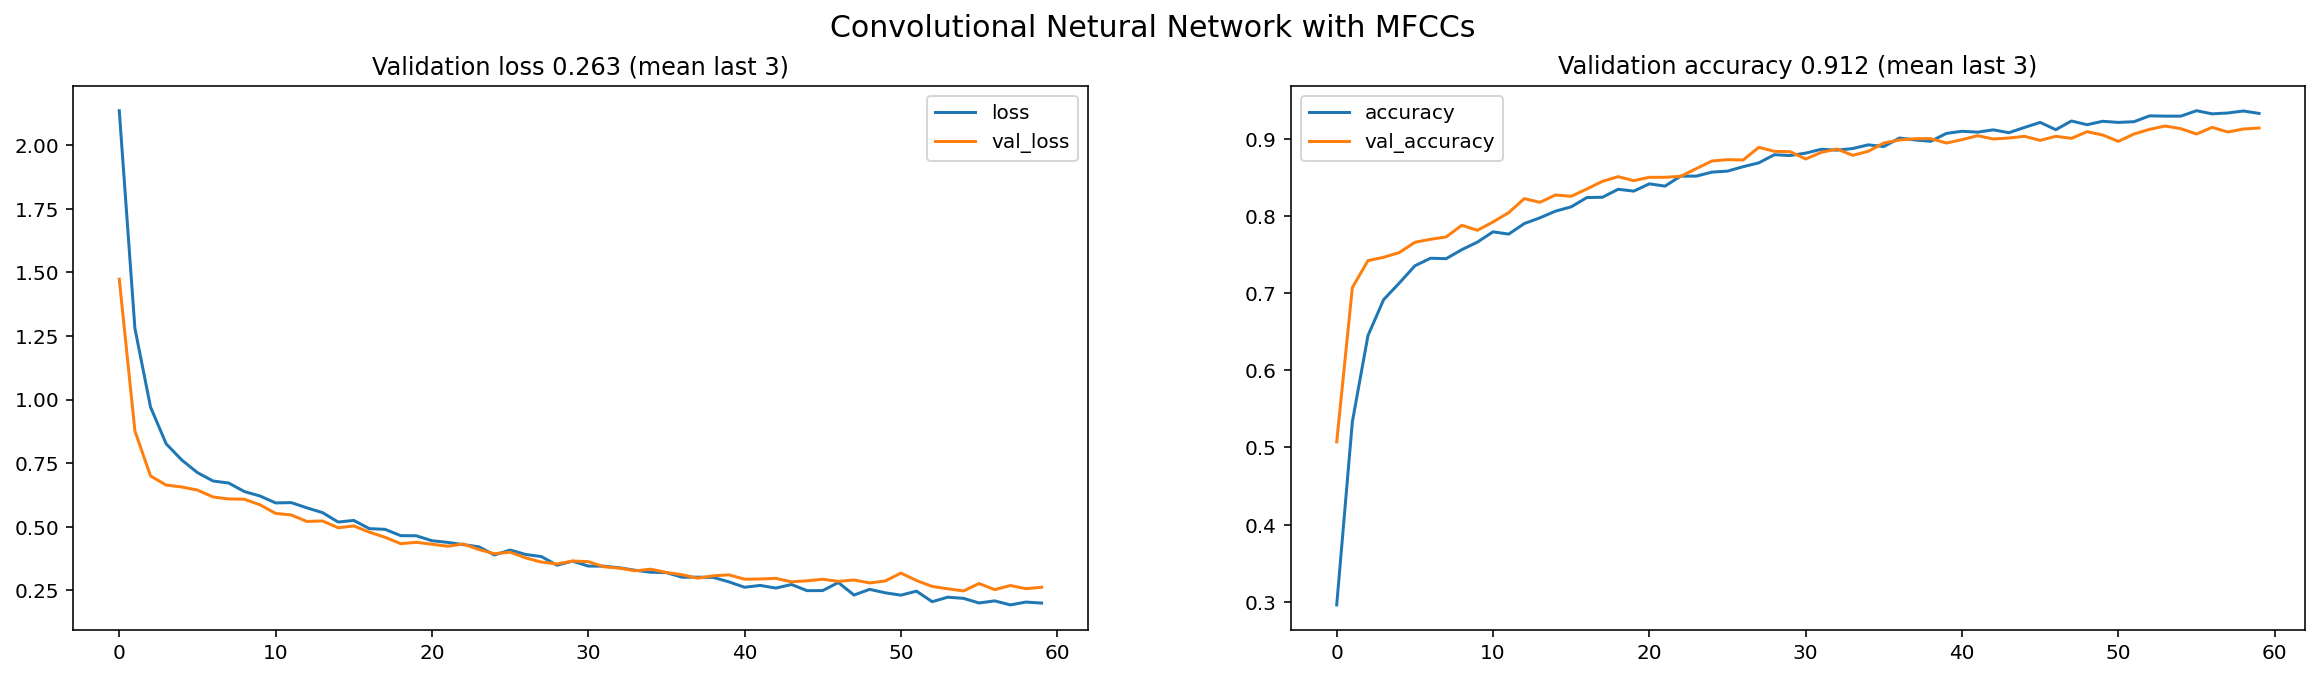

In [19]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Convolutional Netural Network with MFCCs', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.show()

The training and validation accuracies are both improving during the first ~30 epochs, then we start to see signals of overfitting.

### Test set evaluation

In [20]:
# Collect loss and accuracy for the test set
loss_te, accuracy_te = model.evaluate(x_te, y_te)

print("Test loss: {:.2f}".format(loss_te))
print("Test accuracy: {:.2f}%".format(100 * accuracy_te))

27/27 [==============================] - 0s 6ms/step - loss: 0.2719 - accuracy: 0.9114
Test loss: 0.27
Test accuracy: 91.14%


The accuracy on the test set with this method is 92.07%.

We can also see the model performance for each target by using a confusion matrix:

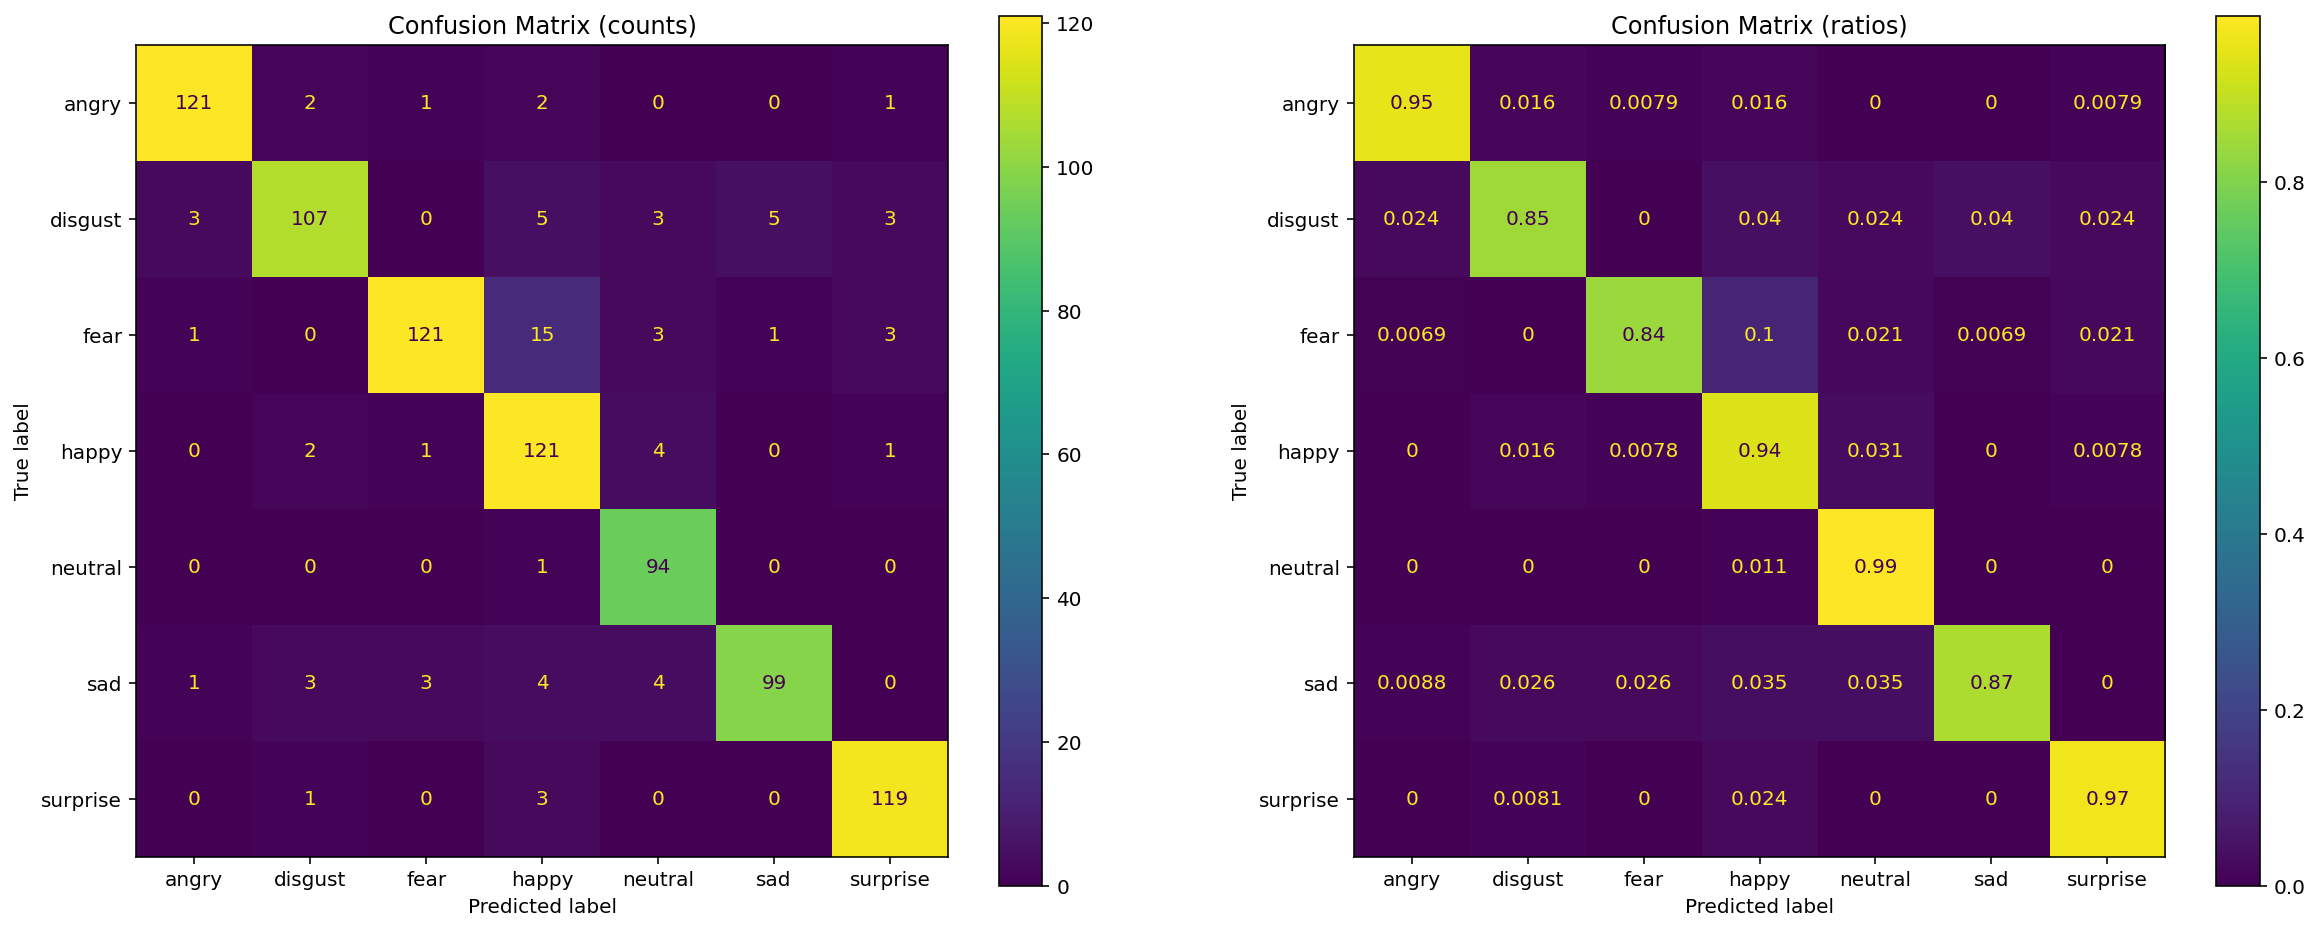

In [21]:
# Compute test set predictions
predictions = model.predict(x_te)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)

In this case the best predictions occurred for the `neutral` and `surprise` emotion, while the worst for the `fear` and `sad` emotions.

In conclusion, we can say that although nowadays there are many different approaches to deal with speech emotion classification problems, MFCCs data have confirmed their effectiveness, which is why they are widely used in sound analysis.